<h1>Introducción</h1>

El análisis de cardiotocogramas (CTG) desempeña un papel crucial en la evaluación prenatal y el monitoreo fetal durante el parto. Estos registros proporcionan información detallada sobre la salud y el bienestar del feto, ayudando a los profesionales de la salud a tomar decisiones informadas para garantizar un parto seguro.

En este trabajo de portafolio, me enfocaré en la construcción y evaluación de modelos de clasificación para predecir la salud fetal utilizando datos de cardiotocogramas. Sin embargo, en lugar de utilizar todas las variables disponibles, me enfocaré en experimentar con aquellas que muestran una correlación alta según el coeficiente de correlación de Kendall-Tau, un tipo de correlación que no asume una distribución específica en los datos, y comparar sus métricas con otros modelos cuyas características serán seleccionadas con la correalación de Pearson que es más comúnmente empleada. Ambos enfoques permiten seleccionar las características más relevantes y reducir la dimensionalidad del conjunto de datos, lo que potencialmente mejora la eficiencia computacional y la interpretación del modelo.

Explorare la construcción de tres modelos de clasificación distintos en este caso máquinas de vectores de soporte (SVM), bosque aleatorio (RF) y aprendizaje profundo o red neuronal (NN), finalmente compararé su desempeño utilizando métricas apropiadas de evaluación de modelos. El objetivo es determinar qué modelo proporciona las predicciones más precisas y útiles para la clasificación de la salud fetal y identificar si el tipo de correlación mencionado es un criterio válido para la selección de variables.

In [1]:
#imporatndo dependencias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import random

In [2]:
raw_df = pd.read_csv("fetal_health.csv")
random.seed(28)

In [3]:
#mapeando la variable respuesta para mayor comodidad de manipulación
raw_df["fetal_health"] = raw_df["fetal_health"].apply(lambda x : int(x))
raw_df["fetal_health"] = raw_df["fetal_health"].map({1:0,2:1,3:2})

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

### Análisis Inicial de la Variable Respuesta

Al analizar la variable respuesta, se observa un desequilibrio significativo entre las clases. En particular, las observaciones correspondientes a los bebés sanos superan en gran proporción a aquellas de bebés con sospecha de patología o con patología confirmada. Este desequilibrio se abordará y corregirá en etapas posteriores del análisis.

([<matplotlib.axis.XTick at 0x1f9905052d0>,
 [Text(0, 0, 'sanos'), Text(1, 0, 'sospechosos'), Text(2, 0, 'paológicos')])

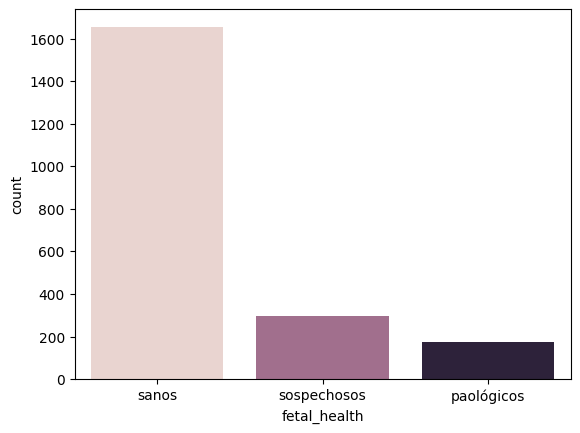

In [5]:
sns.countplot(x= raw_df["fetal_health"],hue =raw_df["fetal_health"], legend=False)
plt.xticks(ticks=plt.xticks()[0], labels = ["sanos", "sospechosos", "patológicos"])

### Selección de características
cómo se describió en la introducción, uno de los objetivos propuestos para el desarrollo de los modelos es extraer las caracterísitcas con una correlación de Kendall más alta y comparar con modelos desarrollados a partir de la selección de características empleando la correlación de Pearson, en la sección siguiente se realizará precisamente esta extracción de características

<Axes: >

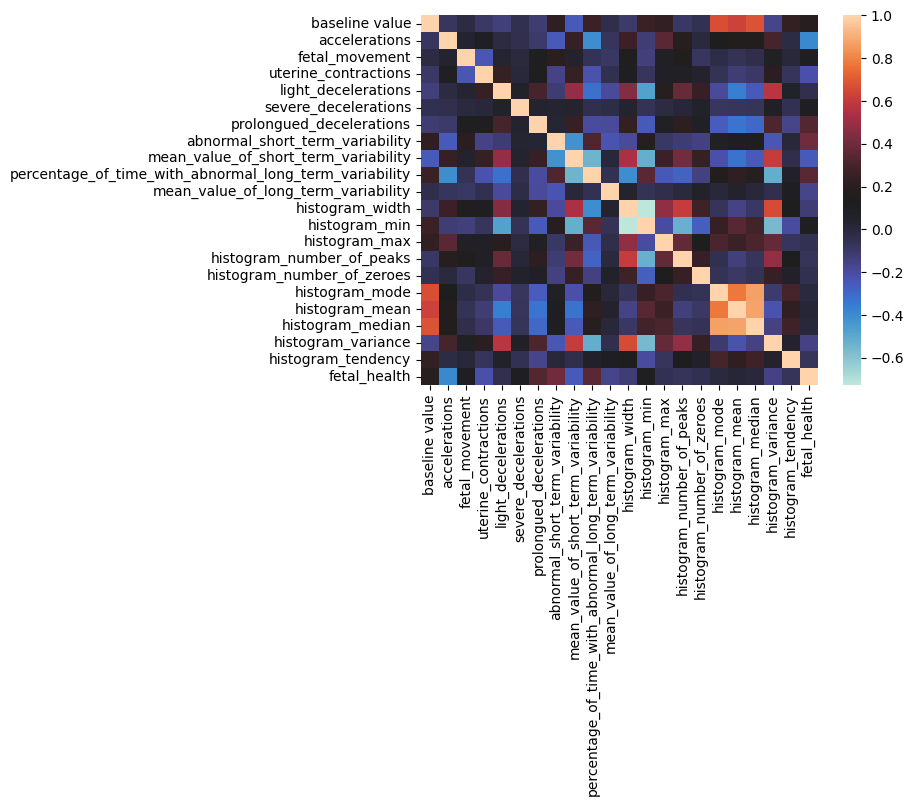

In [39]:
#computación de la correlación de Kendall-Tau
sns.heatmap(raw_df.corr(method="kendall"), cmap="icefire")

<Axes: >

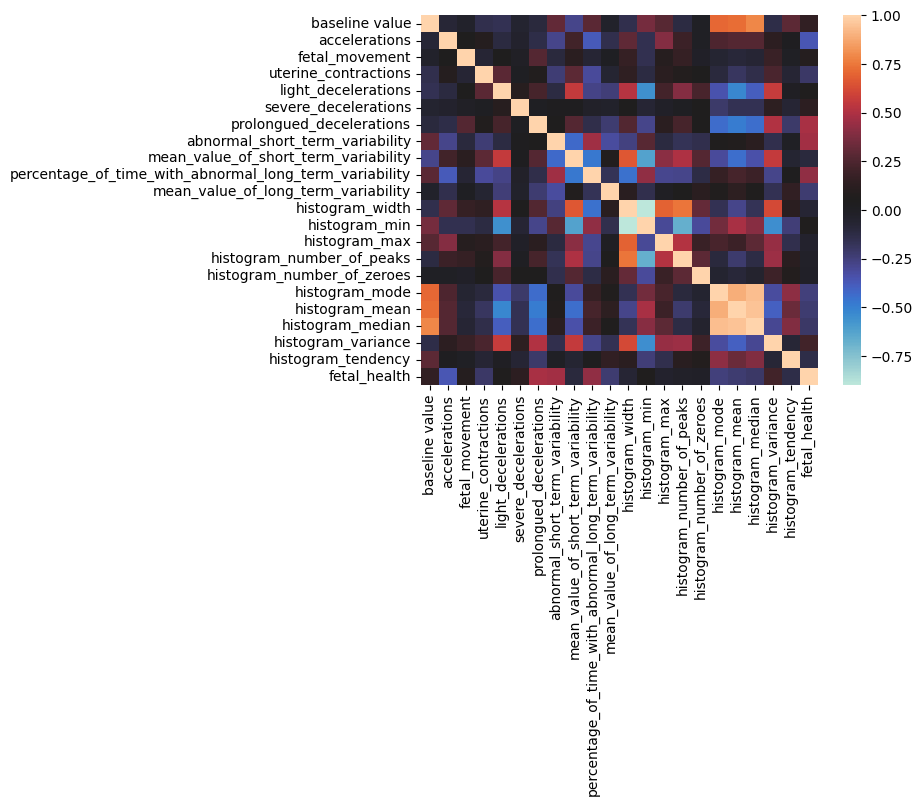

In [7]:
#computación de la correlación de Pearson
sns.heatmap(raw_df.corr(), cmap="icefire")

### Diferencias en la selección
Al realizar la selección de características la principal diferencia radica en que empleando la correlación de pearson parece que las variables histogram_mean, histogram_mode, histogram_median contribuyen de manera mucho más significativa al comportamiento de la varaiable respuesta que en este caso es fetal_health

In [6]:
#Seleccionando variables
df_kendall = raw_df[["accelerations","uterine_contractions","prolongued_decelerations","abnormal_short_term_variability",
    "percentage_of_time_with_abnormal_long_term_variability","mean_value_of_long_term_variability", "fetal_health"]]
df_pearson = raw_df[["accelerations", "uterine_contractions","prolongued_decelerations","abnormal_short_term_variability","percentage_of_time_with_abnormal_long_term_variability",
                    "mean_value_of_long_term_variability","histogram_mode","histogram_mean", "histogram_median","fetal_health"]]

In [7]:
df_kendall.head()

,accelerations,uterine_contractions,prolongued_decelerations,abnormal_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,fetal_health
0,0.000,0.000,0.0,73.0,43.0,2.4,1
1,0.006,0.006,0.0,17.0,0.0,10.4,0
2,0.003,0.008,0.0,16.0,0.0,13.4,0
3,0.003,0.008,0.0,16.0,0.0,23.0,0
4,0.007,0.008,0.0,16.0,0.0,19.9,0


### Balanceo de clases y estandarización
En la siguiente sección se emplea SMOTE, un algoritmo basado en K vecinos más cercanos para simular observaciones con comportamientos similares a los presentados por cada clase ayudando a solucionar el problema del balanceo sin usar métodods de resampleo para evitar información duplicada, se ajustó para que las clases sub representadas tuvieran solo cerca de un 40% menos de represenctación que la de mayor representación y esto con la intención de no introducir sesgos al modelo. Tras esto se llevó a cabo un proceso de escalamiento para que todos las mediciones tuvieran una escala similar.

In [8]:
#aplicando SMOTE y generando particiones en los conjuntos de datos
X_k = df_kendall.drop("fetal_health", axis = 1)
X_p = df_pearson.drop("fetal_health", axis = 1)
y_k= df_kendall["fetal_health"]
y_p= df_pearson["fetal_health"]
sampling = {0:1655, 1:1100, 2:1100}
X_resamp_k, y_resamp_k = SMOTE(sampling_strategy=sampling).fit_resample(X_k, y_k)
X_resamp_p, y_resamp_p = SMOTE(sampling_strategy=sampling).fit_resample(X_p, y_p)

In [9]:
#estandarización de los datos
scaler = StandardScaler()
X_res_k = scaler.fit_transform(X_resamp_k)
X_res_p = scaler.fit_transform(X_resamp_p)

In [10]:
#importacion de estancias de modelos
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report

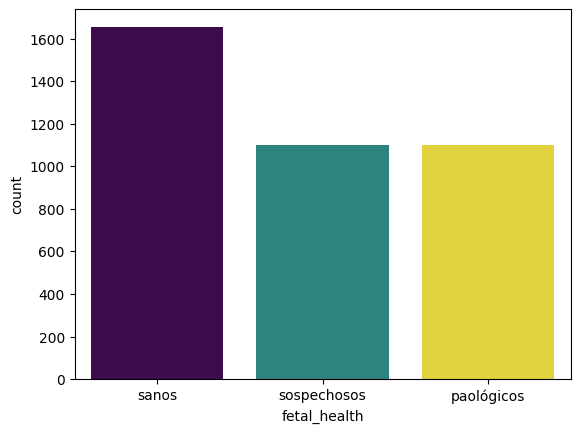

In [11]:
yk_df = pd.DataFrame(y_resamp_k)
yp_df = pd.DataFrame(y_resamp_p)
sns.countplot(x = yp_df["fetal_health"], hue = yp_df["fetal_health"], palette="viridis", legend = False)
plt.xticks(ticks=plt.xticks()[0], labels = ["sanos", "sospechosos", "paológicos"])
plt.show()

### División del conjunto de datos
Ahora se realizará una segmentación del conjunto de datos en datos de entrenamiento, testeo y validación (este último particularmente util para el modelo de aprendizaje profundo) con el fin de de poder probar los modelos creados con información que no han procesado y así obtener métricas acertadas.

In [11]:
#Primero se crean las divisiones de entrenamiento y test
X_trainK, X_testK, y_trainK, y_testK = train_test_split(X_res_k, y_resamp_k, test_size=0.25)
X_trainp, X_testp, y_trainp, y_testp = train_test_split(X_res_p, y_resamp_p, test_size=0.25)

In [12]:
#Posteriormente se extrae un conjunto de de datos de validación para cada conjunto de datos
X_trainK= X_trainK[:int(len(X_trainK)*0.8)]
XVal_K = X_trainK[int(len(X_trainK)*0.8):]
y_trainK= y_trainK[:int(len(y_trainK)*0.8)]
yVal_K = y_trainK[int(len(y_trainK)*0.8):]
X_trainp= X_trainp[:int(len(X_trainp)*0.8)]
XVal_p = X_trainp[int(len(X_trainp)*0.8):]
y_trainp= y_trainp[:int(len(y_trainp)*0.8)]
yVal_p = y_trainp[int(len(y_trainp)*0.8):]

## Generación de modelos
En esta sección se crearán los mismos modelos para ambos conjuntos de datos con el objetivo de compararlos

### Máquinas de vectores de soporte
En este primer algoritmo de clasificación se obtuvo una precisión (accurasy) mayor para el modelo cuyas variables se escogieron empleando el índice de correlación de Pearson con respecto a aquel al conjunto de datos selecccionado con la indice de correlación de Kendall como puede verse en los reportes de clasificación siguientes:

In [13]:
svm_classifier= SVC(kernel = "poly", random_state=1996)
svm_k = svm_classifier.fit(X_trainK, y_trainK)
SVMK_pred = svm_k.predict(X_testK)

In [14]:
svm_p = svm_classifier.fit(X_trainp, y_trainp)
SVMP_pred = svm_p.predict(X_testp)

In [15]:
print(classification_report(y_testK, SVMK_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       422
           1       0.75      0.80      0.77       293
           2       0.94      0.87      0.91       249

    accuracy                           0.84       964
   macro avg       0.85      0.84      0.85       964
weighted avg       0.85      0.84      0.85       964



In [16]:
print(classification_report(y_testp, SVMP_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       411
           1       0.82      0.82      0.82       273
           2       0.95      0.90      0.93       280

    accuracy                           0.89       964
   macro avg       0.89      0.88      0.89       964
weighted avg       0.89      0.89      0.89       964



### Bosque aleatorio
En el siguiente algoritmo puede observarse un desempeño bastante similar entre los modelos generados para ambos conjuntos de datos, presentando la misma precisión, como se puede ver a continuación: 

In [17]:
rfor = RandomForestClassifier(n_estimators= 150, random_state= 28)
Rand_fK = rfor.fit(X_trainK, y_trainK)
RFK_pred = Rand_fK.predict(X_testK)

In [18]:
Rand_fP = rfor.fit(X_trainp, y_trainp)
RFP_pred = Rand_fP.predict(X_testp)

In [19]:
print(classification_report(y_testK, RFK_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       422
           1       0.92      0.92      0.92       293
           2       0.98      0.95      0.97       249

    accuracy                           0.95       964
   macro avg       0.95      0.95      0.95       964
weighted avg       0.95      0.95      0.95       964



In [20]:
print(classification_report(y_testp, RFP_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       411
           1       0.95      0.96      0.96       273
           2       0.99      0.99      0.99       280

    accuracy                           0.97       964
   macro avg       0.97      0.97      0.97       964
weighted avg       0.97      0.97      0.97       964



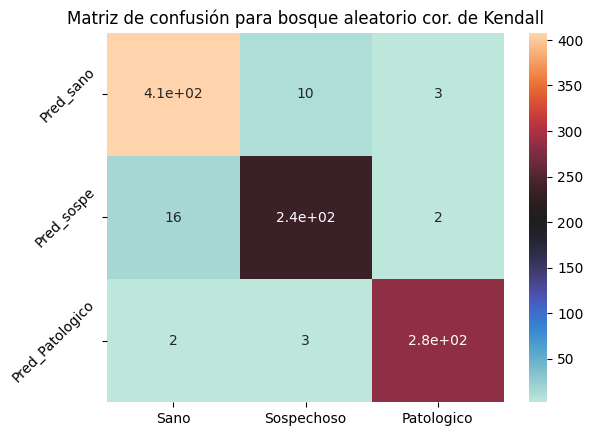

In [28]:
plt.title("Matriz de confusión para bosque aleatorio cor. de Kendall")
sns.heatmap(confusion_matrix(y_testK, RFK_pred), cmap="icefire", annot = True)
plt.xticks(ticks= plt.xticks()[0], labels = ["Sano", "Sospechoso", "Patologico"])
plt.yticks(ticks = plt.yticks()[0], labels= ["Pred_sano","Pred_sospe", "Pred_Patologico"], rotation = 45)
plt.show()

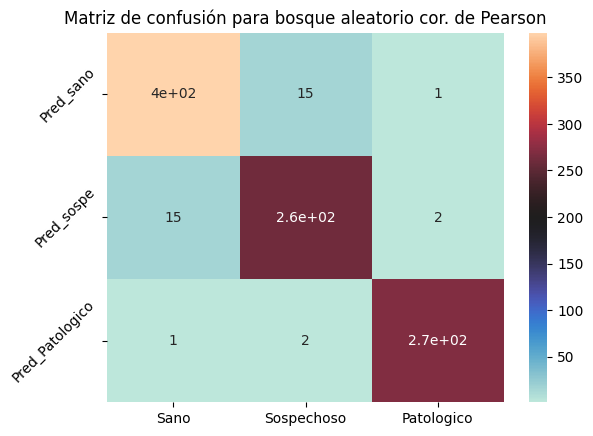

In [29]:
plt.title("Matriz de confusión para bosque aleatorio cor. de Pearson")
sns.heatmap(confusion_matrix(y_testp, RFP_pred), cmap="icefire", annot = True)
plt.xticks(ticks= plt.xticks()[0], labels = ["Sano", "Sospechoso", "Patologico"])
plt.yticks(ticks = plt.yticks()[0], labels= ["Pred_sano","Pred_sospe", "Pred_Patologico"], rotation = 45)
plt.show()

### Aprendizaje profundo
En ese útimo modelo se generó una red neuronal con 3 capas densas (entrenables) lo que quiere decir que cada neurona de cada capa esta conectada a todas las neuronas de la capa siguiente y 2 capas dropout (no entrenables) que ayudan a mejorar el rendimiento del proceso de entrenamiento, esto para cada conjunto de datos, la arquitectura de define a continuación:

In [21]:
modK = Sequential()
modK.add(Dense(100, activation = "relu", input_shape = (6,)))
modK.add(Dropout(0.3))
modK.add(Dense(50, activation="relu"))
modK.add(Dropout(0.2))                
modK.add(Dense(3, activation="softmax"))
modK.compile(optimizer = "adam", loss='sparse_categorical_crossentropy', metrics = ["accuracy"])
hist_k=modK.fit(X_trainK, y_trainK, epochs=100, batch_size = 30, verbose=0,validation_data=(XVal_K,yVal_K))

C:\Users\Juandi\anaconda3\envs\JD_average\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


El entrenamiento realizado para el conjunto de seleccionados con la correlación de Kendall no muestra señales de sobreajuste ya que la curva de aprendizaje del dataset de validación muestra un comportamiento similar al comportaiento de la curva de aprendizaje de los datos de entrenamiento

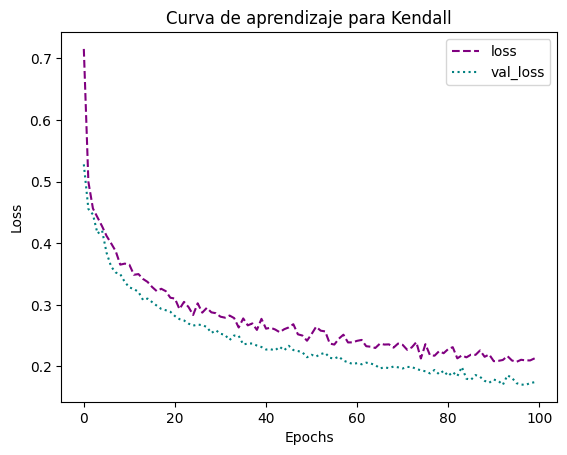

In [22]:
fig = plt.figure()
plt.plot(hist_k.history['loss'], color='purple', label='loss', ls = "--")
plt.plot(hist_k.history['val_loss'], color='teal', label='val_loss', ls = ":")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Curva de aprendizaje para Kendall')
plt.legend()
plt.show()

In [23]:
modP = Sequential()
modP.add(Dense(100, activation = "relu", input_shape = (9,)))
modP.add(Dropout(0.3))
modP.add(Dense(50, activation="relu"))
modP.add(Dropout(0.2))                
modP.add(Dense(3, activation="softmax"))
modP.compile(optimizer = "adam", loss='sparse_categorical_crossentropy', metrics = ["accuracy"])
hist_p = modP.fit(X_trainp, y_trainp, epochs=100, batch_size = 30, verbose=0, validation_data=(XVal_p, yVal_p))

Las curvas descritas en la gráfica siguiente se comportan de manera similar a las curvas de aprendizaje ya mostradas, indicando que no hay un sobre ajuste del modelo

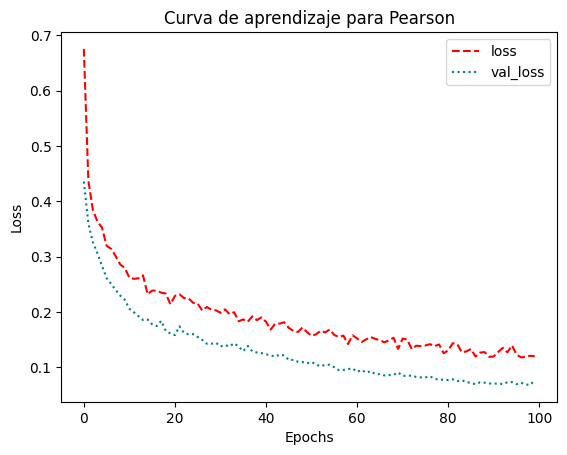

In [24]:
fig = plt.figure()
plt.plot(hist_p.history['loss'], color='red', label='loss', ls = "--")
plt.plot(hist_p.history['val_loss'], color='teal', label='val_loss', ls = ":")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Curva de aprendizaje para Pearson')
plt.legend()
plt.show()

In [25]:
#generando predicciones
K_pred = modK.predict(X_testK)
P_pred = modP.predict(X_testp)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [26]:
K_pred=pd.DataFrame(K_pred, columns=["1","2", "3"])
P_pred=pd.DataFrame(P_pred, columns=["1","2", "3"])
K_pred = K_pred.apply(lambda x : round(x))
P_pred = P_pred.apply(lambda x : round(x))

In [27]:
def encode_inverso(df):
    return df.idxmax(axis=1)
K_prNN = encode_inverso(K_pred)
P_prNN = encode_inverso(P_pred)

In [28]:
K_prNN =pd.DataFrame(K_prNN, columns=["fetal_health"])
K_prNN["fetal_health"] = K_prNN["fetal_health"].apply(lambda x: int(x))
K_prNN.value_counts()

fetal_health
1               410
2               313
3               241
Name: count, dtype: int64

In [29]:
P_prNN =pd.DataFrame(P_prNN, columns=["fetal_health"])
P_prNN["fetal_health"] = P_prNN["fetal_health"].apply(lambda x: int(x))
P_prNN.value_counts()

fetal_health
1               397
2               285
3               282
Name: count, dtype: int64

In [30]:
#remapeando valores de variable respuesta a sus cifras originales para evitar confusión en el reporte de clasificación
y_testp= pd.DataFrame(y_testp,columns=["fetal_health"])
y_testK= pd.DataFrame(y_testK,columns=["fetal_health"])
y_testK["fetal_health"] = y_testK["fetal_health"].map({0:1, 1:2, 2:3})
y_testp["fetal_health"] = y_testp["fetal_health"].map({0:1, 1:2, 2:3})

Los reportes de clasificación para los modelos de aprendizaje profundo aplicado a los 2 conjuntos de datos permite observar que el conjunto seleccionado con la correlación de Pearson desempeñó de manera levemente superior, los resultados a continuación

In [31]:
print(classification_report(y_testK, K_prNN))

              precision    recall  f1-score   support

           1       0.93      0.90      0.92       422
           2       0.85      0.91      0.88       293
           3       0.97      0.94      0.96       249

    accuracy                           0.91       964
   macro avg       0.92      0.92      0.92       964
weighted avg       0.92      0.91      0.92       964



In [32]:
print(classification_report(y_testp, P_prNN))

              precision    recall  f1-score   support

           1       0.97      0.93      0.95       411
           2       0.91      0.95      0.93       273
           3       0.96      0.97      0.96       280

    accuracy                           0.95       964
   macro avg       0.95      0.95      0.95       964
weighted avg       0.95      0.95      0.95       964



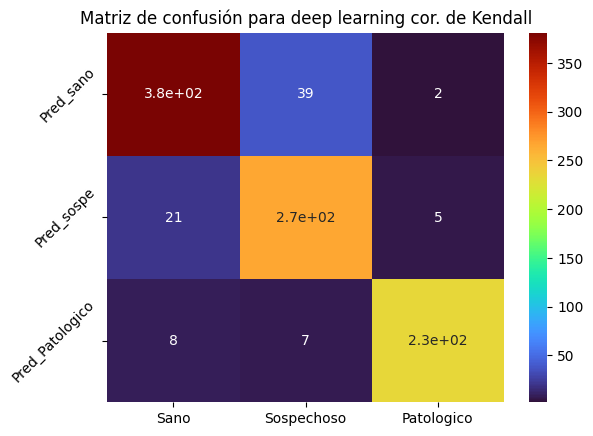

In [37]:
plt.title("Matriz de confusión para deep learning cor. de Kendall")
sns.heatmap(confusion_matrix(y_testK, K_prNN), cmap="turbo", annot = True)
plt.xticks(ticks= plt.xticks()[0], labels = ["Sano", "Sospechoso", "Patologico"])
plt.yticks(ticks = plt.yticks()[0], labels= ["Pred_sano","Pred_sospe", "Pred_Patologico"], rotation = 45)
plt.show()

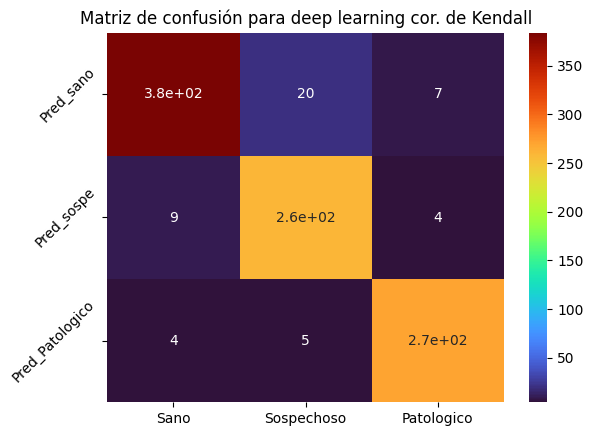

In [38]:
plt.title("Matriz de confusión para deep learning cor. de Kendall")
sns.heatmap(confusion_matrix(y_testp, P_prNN), cmap="turbo", annot = True)
plt.xticks(ticks= plt.xticks()[0], labels = ["Sano", "Sospechoso", "Patologico"])
plt.yticks(ticks = plt.yticks()[0], labels= ["Pred_sano","Pred_sospe", "Pred_Patologico"], rotation = 45)
plt.show()

## Conclusiones

En este trabajo de portafolio, se llevó a cabo un análisis exhaustivo utilizando un dataset de cardiotocogramas con el objetivo de seleccionar las variables predictoras más relevantes y construir modelos predictivos eficientes. Para la selección de variables, se emplearon dos métodos de correlación distintos: Pearson y Kendall. Posteriormente, se desarrollaron y evaluaron tres modelos diferentes: SVM (Máquinas de Vectores de Soporte), Random Forest y un modelo de Aprendizaje Profundo.

### Evaluación de los Métodos de Correlación

- **Correlación de Pearson**: Este método mide la relación lineal entre variables y es sensible a las relaciones lineales directas. Se observó que las variables seleccionadas utilizando la correlación de Pearson proporcionaron un conjunto de datos optimizado para el modelado predictivo.

- **Correlación de Kendall**: Este método mide la asociación ordinal entre variables, siendo más robusto ante distribuciones no normales y relaciones no lineales. Aunque este enfoque es útil en ciertos contextos, en este caso particular no superó el rendimiento obtenido con la correlación de Pearson.

### Desempeño de los Modelos

Tras la selección de variables, se construyeron tres modelos predictivos y se evaluaron utilizando métricas estándar. Las principales observaciones fueron:

- **SVM (Máquinas de Vectores de Soporte)**: Este modelo mostró una precisión robusta en ambos conjuntos de datos (Pearson y Kendall), aunque con un desempeño ligeramente superior en el conjunto seleccionado por la correlación de Pearson.
  
- **Random Forest**: Al igual que el SVM, el modelo Random Forest presentó una mayor precisión y estabilidad en las predicciones cuando se utilizó el conjunto de datos seleccionado con la correlación de Pearson.
  
- **Aprendizaje Profundo**: El modelo de Aprendizaje Profundo demostró ser el más sensible a la calidad de las variables seleccionadas, alcanzando su mejor desempeño con el conjunto de datos basado en la correlación de Pearson.

### Conclusión Final

La comparación de los métodos de correlación y los modelos predictivos reveló que la selección de variables basada en la correlación de Pearson proporcionó un conjunto de datos más adecuado para el modelado predictivo en el contexto de este estudio. Los modelos SVM, Random Forest y de Aprendizaje Profundo, todos, se desempeñaron de manera levemente superior con las variables seleccionadas mediante la correlación de Pearson.

Este hallazgo sugiere que, para este dataset específico de cardiotocogramas, la relación lineal entre variables capturada por la correlación de Pearson es más relevante y útil para el desarrollo de modelos predictivos eficaces. No obstante, es importante considerar que la eficacia de los métodos de selección de variables puede variar según el dataset y el dominio de aplicación, por lo que futuras investigaciones podrían explorar combinaciones híbridas de métodos de correlación o la aplicación de técnicas de selección de características más avanzadas para mejorar aún más el rendimiento predictivo.